# Homework Assignment: Exploring K-Means Algorithm
### Objective
- Implement K-Means clustering using object-oriented programming in Python.
- Explore the algorithm's complexity in terms of time and space with respect to its variables.
- Apply K-Means for image compression by mapping pixel space into and reducing the number of colors.
Practice good coding practice : pep8, unit testing, docstrings, etc.

### Task 1: Implementing K-Means Algorithm

- 1. Write a Python class called KMeans that encapsulates the K-Means clustering algorithm

- 2. Ensure taht your code follows PEP 8 style guidelines, including proper indentation, spacing, and line lengths

- 3. Use meaningful variable names that convey the purpose of each variable

- 4. Include docstrings for class, methods, and significant blocks of code

- 5. Implement a thorough set of tests for your K-Means implementation using a testing library like unittest or pytest

- 6. Consider edge cases and unexpected inputs in your testing strategy

In [2]:
from PIL import Image, ImageOps
import numpy as np
import pytest
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_blobs
#from IPython.display import Image
#from PIL import Image as PILImage

In [3]:
class KMeans:
    def __init__(self, n_clusters=3, max_iterations=100, random_state=None):
        """
        Initialize KMeans clustering algorithm.

        Parameters:
        - n_clusters: Number of clusters (default is 3).
        - max_iterations: Maximum number of iterations (default is 100).
        - random_state: Seed for random number generation (default is None).
        """
        self.n_clusters = n_clusters
        self.max_iterations = max_iterations
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def fit(self, data):
        """
        Fit the KMeans algorithm to the input data.

        Parameters:
        - data: Numpy array of shape (m, n) representing m data points in an n-dimensional space.
        """
        if data.shape[0] < self.n_clusters:
            raise ValueError(
                "Number of cluster's cannot be more than number of data points.")

        np.random.seed(self.random_state)
        # STEP ONE: Randomly choose n_cluster points to set as initual mu_js
        self.centroids = data[np.random.choice(
            data.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iterations):
            # STEP TWO: Assign all observations in X to the nearest centroid
            labels = self.predict(data)

            # STEP THREE: Recalculate the centroid as the average of the
            # observations in Cj
            new_centroids = np.zeros((self.n_clusters, data.shape[1]))
            for i in range(self.n_clusters):
                # extract data points assigned to cluster i
                cluster_points = data[labels == i]
                if cluster_points.size == 0:  # checks for empty clusters
                    # reinitialize to a new random data point
                    new_centroids[i] = data[np.random.choice(data.shape[0])]

                else:
                    new_centroids[i] = cluster_points.mean(axis=0)

            # Check for convergence (increases efficiency)
            if np.allclose(
                    self.centroids,
                    new_centroids,
                    atol=1e-6):  # determines convergence when numbers are close enough
                break

            self.centroids = np.array(new_centroids)

        # updating labels with final assignments
        self.labels = self.predict(data)

    def predict(self, data):
        """
        Assign data points to the nearest cluster based on current centroids.

        Parameters:
        - data: Numpy array of shape (m, n) representing m data points in an n-dimensional space.

        Returns:
        - labels: Array of cluster labels assigned to each data point.
        """
        distances = np.sqrt(
            ((data - self.centroids[:, np.newaxis])**2).sum(axis=2))
        # returns index of best centroid for each data point
        labels = np.argmin(distances, axis=0)
        return labels

    def get_centroids(self):
        """
        Get the current centroids after fitting the algorithm.

        Returns:
        - centroids: Numpy array representing the centroids of clusters.
        """
        return self.centroids


### Tests:

In [4]:
def test_initialization():
    """
    Validates the correct initialization of KMeans class attributes. It checks that the `n_clusters`,
    `max_iterations`, and `random_state` are correctly assigned, and verifies `centroids` and `labels`
    are initialized as None. This ensures the class is properly set up before fitting any data.
    """
    kmeans = KMeans(n_clusters=4, max_iterations=50, random_state=42)
    assert kmeans.n_clusters == 4
    assert kmeans.max_iterations == 50
    assert kmeans.random_state == 42
    assert kmeans.centroids is None
    assert kmeans.labels is None


test_initialization()

In [5]:
def test_fit():
    """
    Verifies that the KMeans algorithm can be fitted to a small dataset and correctly
    identifies two centroids. It checks that centroid count matches the specified number
    of clusters.
    """
    data = np.array([[1, 2], [3, 4], [5, 6],
                     [10, 20], [20, 30], [10, 5]])
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(data)
    assert kmeans.centroids is not None
    assert len(kmeans.centroids) == 2


test_fit()

In [6]:
def test_predict():
    """
    Test the predict method of the KMeans class.

    This function creates a mock dataset of six 2D points that are clearly clustered
    into three groups. It initializes a KMeans instance with predefined centroids.
    The test verifies that the predict method correctly assigns each data point
    to the nearest centroid, by comparing the predicted labels against expected labels.
    """

    # Mock data: 6 points in a 2D space
    data = np.array([
        [1, 2],  # Cluster 1
        [1, 1],  # Cluster 1
        [10, 10],  # Cluster 2
        [10, 11],  # Cluster 2
        [-5, -5],  # Cluster 3
        [-5, -6],  # Cluster 3
    ])

    # Initialize KMeans with 3 clusters, set centroids manually for the test
    kmeans = KMeans(n_clusters=3)
    kmeans.centroids = np.array([
        [1, 1.5],  # Centroid of cluster 1
        [10, 10.5],  # Centroid of cluster 2
        [-5, -5.5],  # Centroid of cluster 3
    ])

    # Expected labels corresponding to the nearest centroid
    expected_labels = np.array([0, 0, 1, 1, 2, 2])

    # Predict labels
    predicted_labels = kmeans.predict(data)

    # Assert that the predicted labels match the expected labels
    assert np.array_equal(predicted_labels, expected_labels)


test_predict()

In [7]:
class TestableKMeans(KMeans):
    """
    Subclass of KMeans to test empty cluster handling by initializing one centroid far from data.
    """

    def __init__(self, *args, **kwargs):
        """Initialize TestableKMeans with superclass arguments."""
        super().__init__(*args, **kwargs)

    def fit(self, data):
        """
        Fit model while forcing one centroid to start far from data to simulate empty cluster.
        """
        np.random.seed(self.random_state)
        self.centroids = np.vstack(([9999, 9999], data[np.random.choice(
            data.shape[0], self.n_clusters - 1, replace=False), :]))
        super().fit(data)


def test_kmeans_handles_empty_clusters():
    """
    Test that KMeans can handle empty clusters by reinitializing centroids
    for any cluster that has no points assigned to it.
    """
    # Create a dataset where one cluster is likely to be empty with random
    # initialization
    np.random.seed(42)
    data = np.random.randn(100, 2)  # Simple dataset

    kmeans = TestableKMeans(n_clusters=3, max_iterations=100, random_state=42)
    kmeans.fit(data)

    # Check that all clusters have some points assigned to them after fitting
    for i in range(kmeans.n_clusters):
        cluster_points = data[kmeans.labels == i]
        assert cluster_points.size > 0, f"Cluster {i} is empty after reinitialization."

    # Check that the algorithm has moved the outlier centroid to a reasonable
    # location
    assert not np.allclose(
        kmeans.centroids[0], [
            9999, 9999], atol=1), "Centroid was not reinitialized from the outlier position."


test_kmeans_handles_empty_clusters()

In [8]:
def test_convergence():
    """
    Test KMeans for convergence by ensuring centroids do not change significantly
    in the last iterations, indicating stability and convergence.
    """
    data = np.array([[1, 2], [1, 4], [1, 0],
                     [10, 2], [10, 4], [10, 0]])
    max_iterations = 100
    kmeans = KMeans(
        n_clusters=2,
        max_iterations=max_iterations,
        random_state=42)
    kmeans.fit(data)

    # Capture the final centroids after fitting
    final_centroids = kmeans.centroids

    # Run one more iteration manually
    kmeans.max_iterations += 1
    kmeans.fit(data)

    # Compare the centroids after the additional iteration to the final
    # centroids
    assert np.allclose(final_centroids, kmeans.centroids, atol=1e-4), \
        "Centroids changed after the max_iterations, suggesting convergence was not achieved."


test_convergence()

In [9]:
def test_single_data_point():
    """Test KMeans with a dataset containing only a single data point."""
    data = np.array([[1, 2]])
    kmeans = KMeans(n_clusters=2, random_state=42)
    # Assuming your implementation raises an exception in this case
    with pytest.raises(Exception):
        kmeans.fit(data)


test_single_data_point()

In [10]:
def test_identical_data_points():
    """Test KMeans with a dataset where all data points are identical."""
    data = np.array([[1, 1], [1, 1], [1, 1]])
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(data)
    # Check that the algorithm does not crash and handles the situation
    # gracefully
    assert kmeans.centroids is not None
    # Centroids may end up being the same or handled in a special way by the
    # implementation
    predictions = kmeans.predict(data)
    # All data points should be assigned to one cluster or distributed based
    # on the implementation specifics
    assert set(predictions) <= {0, 1}


test_identical_data_points()

In [11]:
def test_more_clusters_than_data_points():
    """Test KMeans with more clusters requested than there are data points."""
    data = np.array([[1, 2], [3, 4]])
    kmeans = KMeans(n_clusters=3, random_state=42)
    with pytest.raises(Exception):
        kmeans.fit(data)


test_more_clusters_than_data_points()

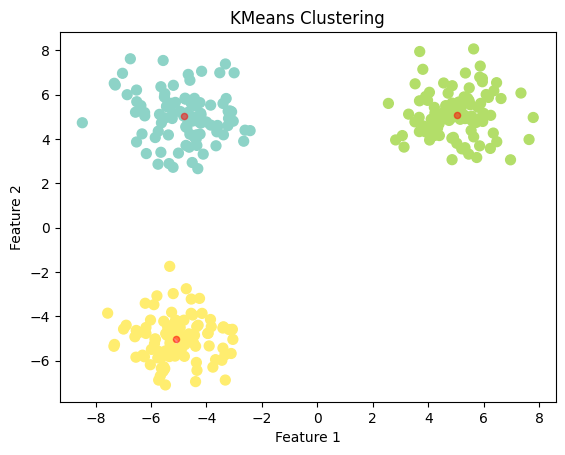

In [12]:
# We've passed our tests! Let's also visualize how this algorithm is working

data1 = np.random.randn(100, 2) + np.array([5, 5])
data2 = np.random.randn(100, 2) + np.array([-5, -5])
data3 = np.random.randn(100, 2) + np.array([-5, 5])
data = np.vstack((data1, data2, data3))

# Instantiate KMeans
kmeans = KMeans(n_clusters=3, max_iterations=30, random_state=42)

# Fit KMeans
kmeans.fit(data)

# Plotting
plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels, s=50, cmap='Set3')
centroids = np.array(kmeans.centroids)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=20, alpha=0.5)
plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### Task 2: Complexity Exploration

1. Analyze the time complexity of your K-Means implementation. Consider the impact of the number of points (m), clusters (K), iterations (I), and attributes (n)

2. Implement experiments to measure the running time for varying values of these parameters

3. Create plots to visualize the growth in running time as each variable changes. Discuss the observed trends.

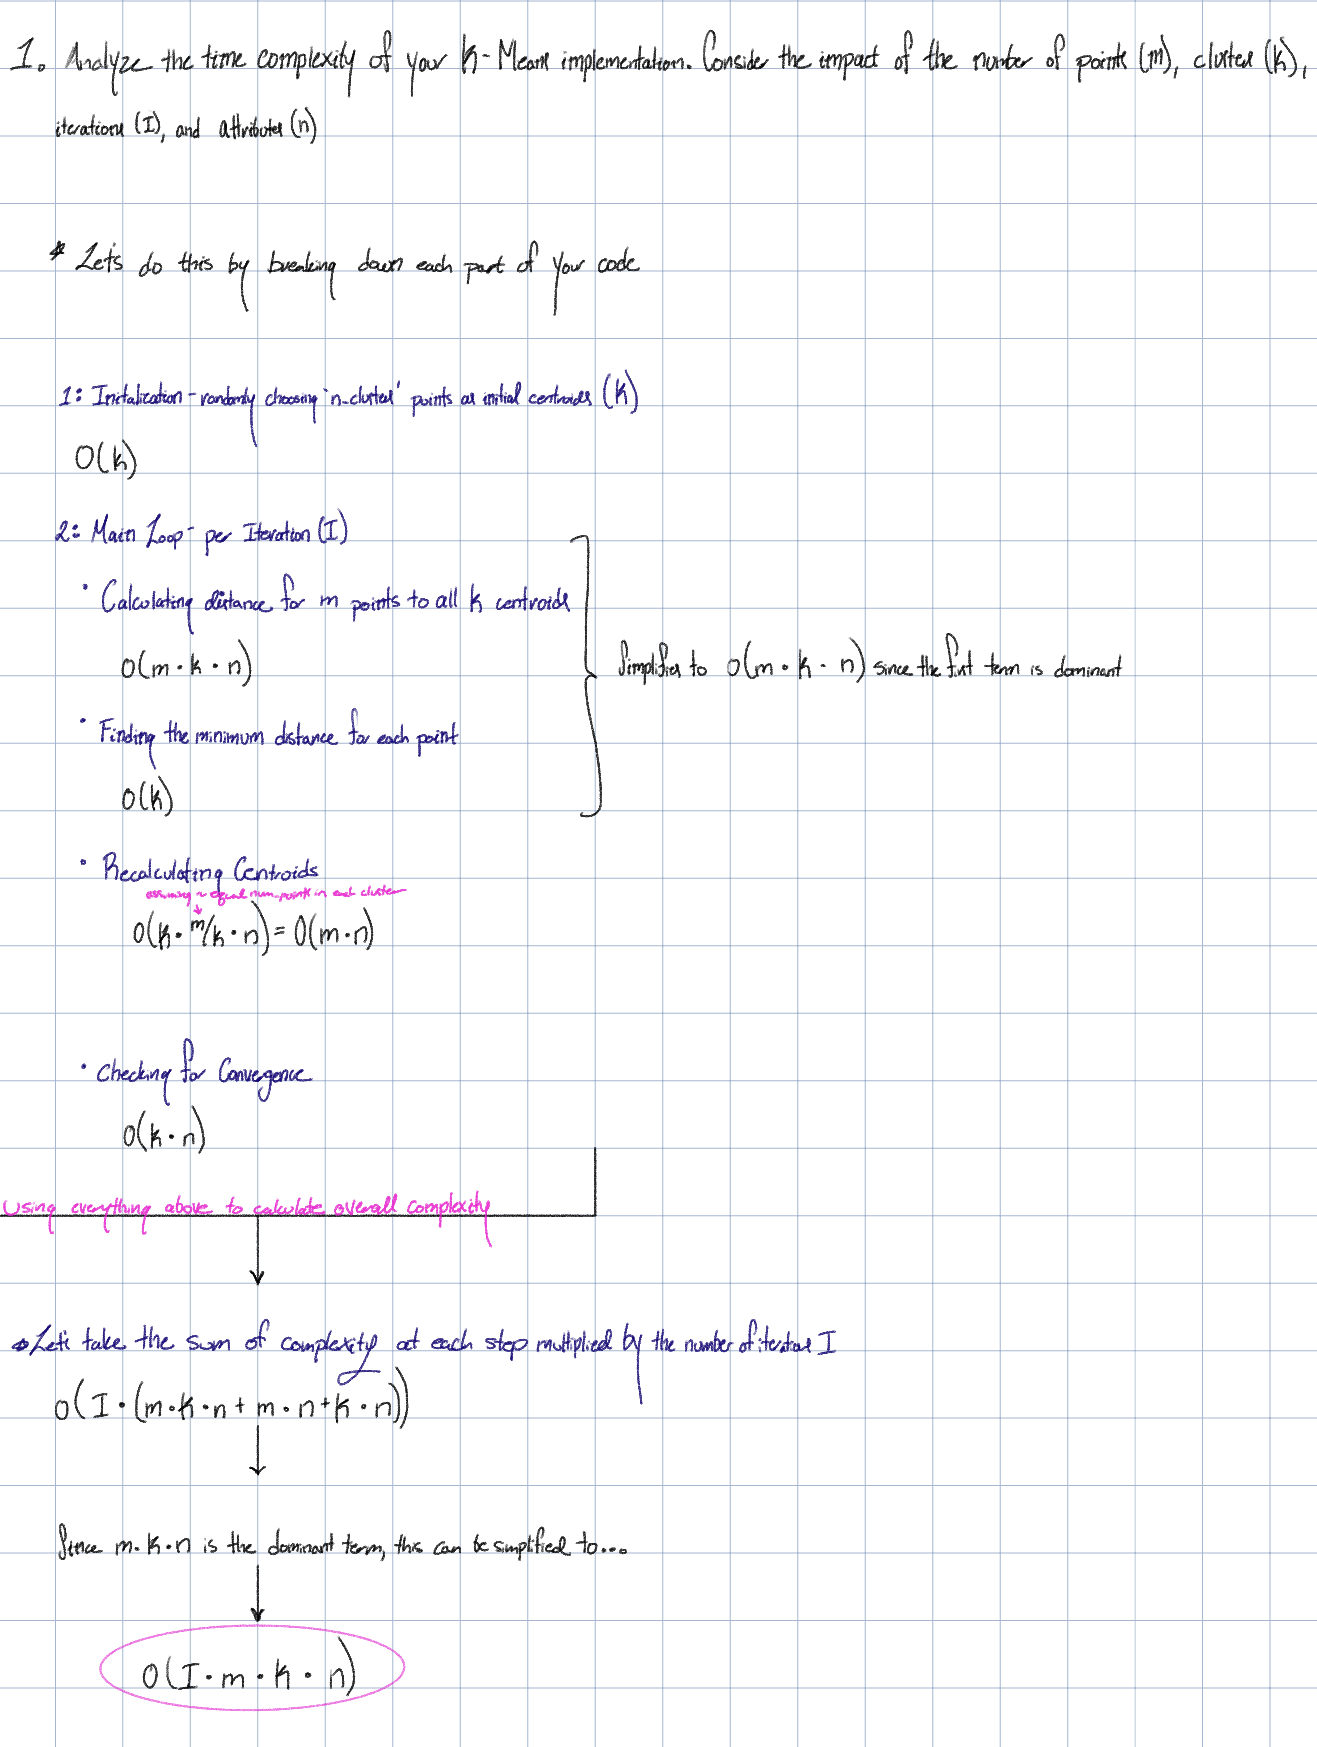

In [13]:
Image.open("/Users/ianduke/Desktop/MSDS_Spring_I/Algorithms/time_complexity_calculation.jpeg")


In [14]:
# Experiment with varying number of points (m)
def run_experiment_m(range_of_m, fixed_n, fixed_K, fixed_I):
    times_m = []
    for m in range_of_m:
        data, _ = make_blobs(n_samples=m, n_features=fixed_n, centers=fixed_K)
        kmeans = KMeans(
            n_clusters=fixed_K,
            max_iterations=fixed_I,
            random_state=42)

        start = time.time()
        kmeans.fit(data)
        end = time.time()

        times_m.append(end - start)

    return times_m

# Experiment with varying number of klusters (k)
def run_experiment_k(fixed_m, fixed_n, range_of_k, fixed_I):
    times_k = []
    for K in range_of_k:
        data, _ = make_blobs(n_samples=fixed_m, n_features=fixed_n, centers=K)
        kmeans = KMeans(n_clusters=K, max_iterations=fixed_I, random_state=42)

        start = time.time()
        kmeans.fit(data)
        end = time.time()

        times_k.append(end - start)

    return times_k

# Experiment with varying number of iterations (I)
def run_experiment_i(fixed_m, fixed_n, fixed_K, range_of_I):
    times_i = []
    for I in range_of_I:
        data, _ = make_blobs(
            n_samples=fixed_m, n_features=fixed_n, centers=fixed_K)
        kmeans = KMeans(n_clusters=fixed_K, max_iterations=I, random_state=42)

        start = time.time()
        kmeans.fit(data)
        end = time.time()

        times_i.append(end - start)

    return times_i

# Experiment with varying numbers of features (n)
def run_experiment_n(fixed_m, range_of_n, fixed_K, fixed_I):
    times_n = []
    for n in range_of_n:
        data, _ = make_blobs(n_samples=fixed_m, n_features=n, centers=fixed_K)
        kmeans = KMeans(
            n_clusters=fixed_K,
            max_iterations=fixed_I,
            random_state=47)

        start = time.time()
        kmeans.fit(data)
        end = time.time()

        times_n.append(end - start)

    return times_n

In [15]:
def plot_results(range_of_variable, times_variable, x_label, y_label, title):
    plt.figure(figsize=(12, 6))

    # Plot actual experimental results
    plt.subplot(1, 2, 1)
    plt.plot(
        range_of_variable,
        times_variable,
        marker='o',
        label='Actual Running Time')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()

    # Plot expected results based on theoretical time complexity
    plt.subplot(1, 2, 2)
    plt.plot(
        range_of_variable,
        expected_times_variable_normalized,
        marker='o',
        linestyle='--',
        color='r',
        label='Expected Running Time (Normalized)')
    plt.title('Expected Time Complexity')
    plt.xlabel(x_label)
    plt.ylabel('Normalized ' + y_label)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [16]:
fixed_m = 3000
fixed_n = 20
fixed_I = 10
fixed_K = 30
range_of_variable = [i for i in range(30, 200, 1)]

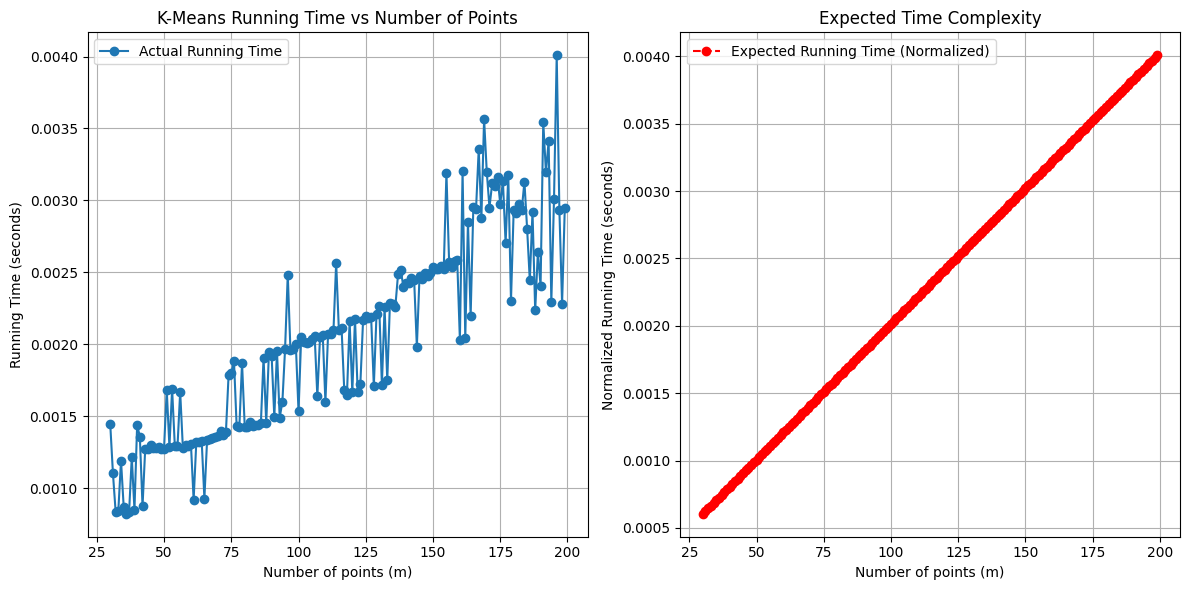

In [39]:
times_variable = run_experiment_m(
    range_of_m=range_of_variable,
    fixed_n=fixed_n,
    fixed_K=fixed_K,
    fixed_I=fixed_I)
expected_times_variable = fixed_I * \
    np.array(range_of_variable) * fixed_K * fixed_n
expected_times_variable_normalized = expected_times_variable / \
    np.max(expected_times_variable) * np.max(times_variable)
plot_results(
    range_of_variable,
    times_variable,
    'Number of points (m)',
    'Running Time (seconds)',
    'K-Means Running Time vs Number of Points')

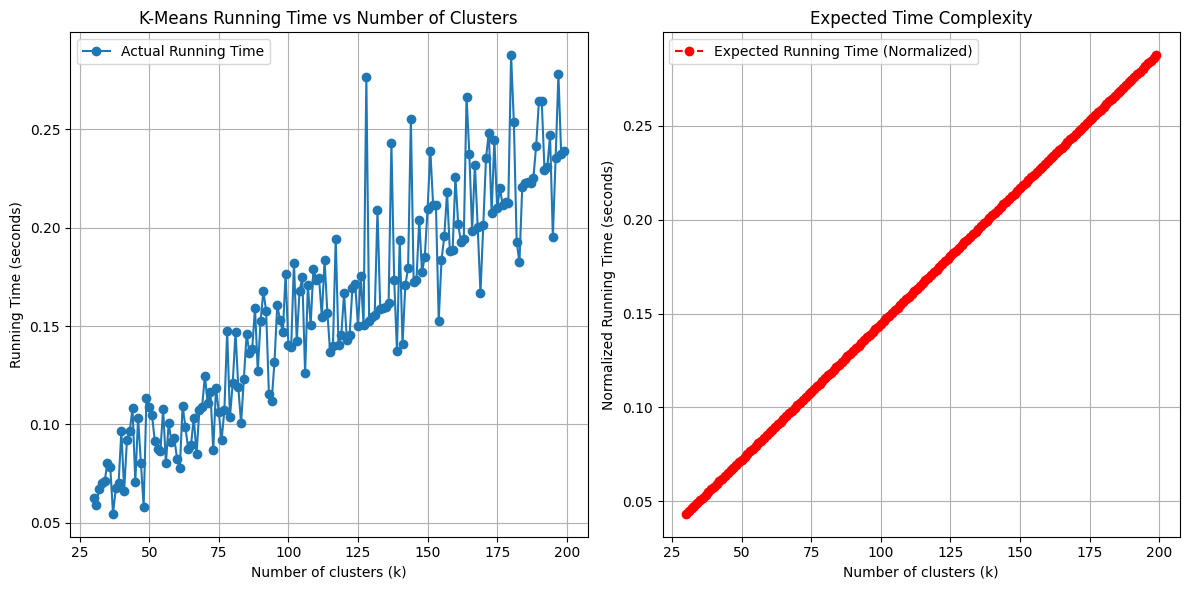

In [18]:
# Running the experiments
times_variable = run_experiment_k(
    fixed_m,
    fixed_n,
    range_of_k=range_of_variable,
    fixed_I=fixed_I)
expected_times_variable = fixed_I * fixed_m * \
    np.array(range_of_variable) * fixed_n
expected_times_variable_normalized = expected_times_variable / \
    np.max(expected_times_variable) * np.max(times_variable)
plot_results(
    range_of_variable,
    times_variable,
    'Number of clusters (k)',
    'Running Time (seconds)',
    'K-Means Running Time vs Number of Clusters')

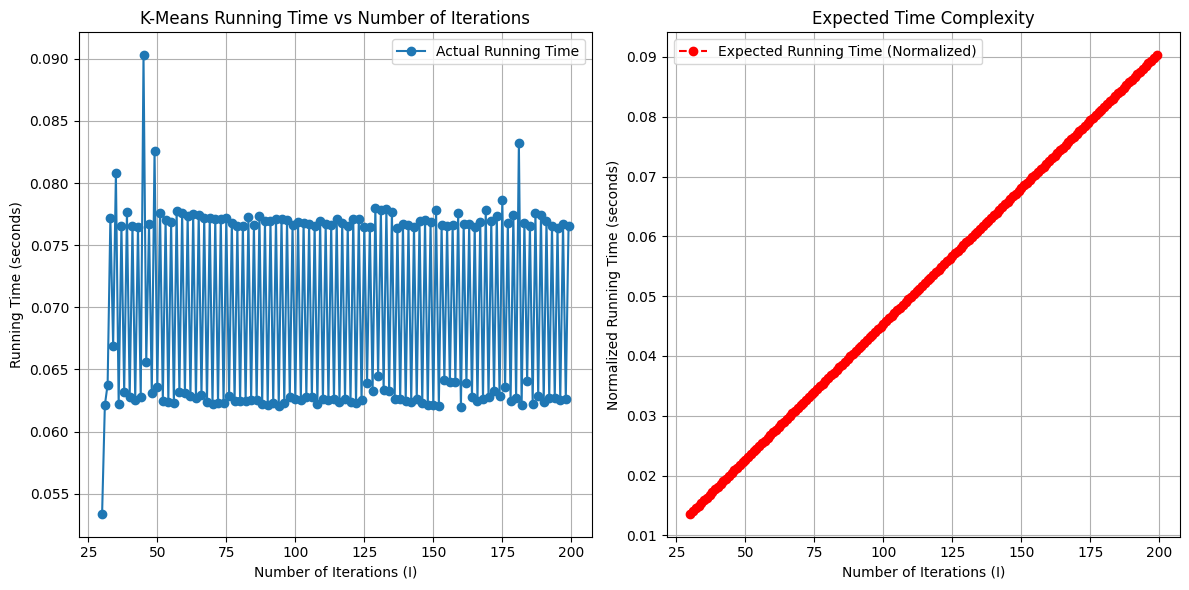

In [19]:
times_variable = run_experiment_i(
    fixed_m,
    fixed_n,
    fixed_K,
    range_of_I=range_of_variable)
expected_times_variable = np.array(
    range_of_variable) * fixed_m * fixed_K * fixed_n
expected_times_variable_normalized = expected_times_variable / \
    np.max(expected_times_variable) * np.max(times_variable)
plot_results(
    range_of_variable,
    times_variable,
    'Number of Iterations (I)',
    'Running Time (seconds)',
    'K-Means Running Time vs Number of Iterations')

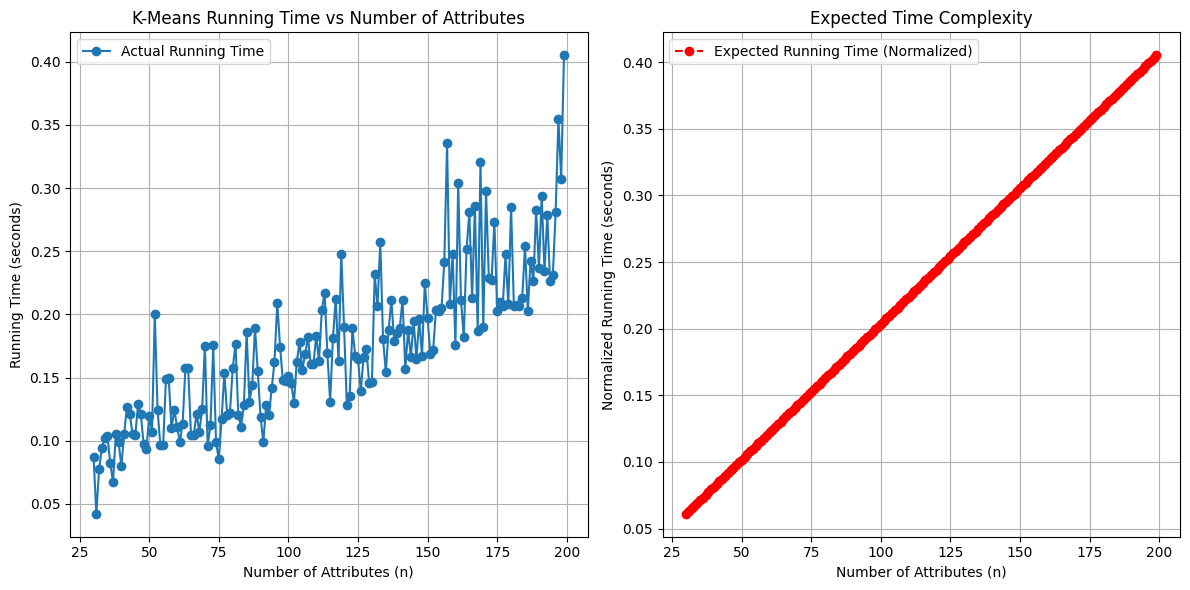

In [20]:
times_variable = run_experiment_n(
    fixed_m,
    range_of_n=range_of_variable,
    fixed_K=fixed_K,
    fixed_I=fixed_I)
expected_times_variable = np.array(
    range_of_variable) * fixed_m * fixed_K * fixed_n
expected_times_variable_normalized = expected_times_variable / \
    np.max(expected_times_variable) * np.max(times_variable)
plot_results(
    range_of_variable,
    times_variable,
    'Number of Attributes (n)',
    'Running Time (seconds)',
    'K-Means Running Time vs Number of Attributes')


Yay! We observe through our experiments that the actual runtime largely follows what we expected via manual calculation of time complexity; the number of points (m), clusters (K), iterations (I), and attributes (n) all have approximately linear relationships with the amount of time it takes to execute the KMeans algorithm. For example, we can see in our experiments that, generally, as the number of clusters increases the running time increases.

It is, however, important to note that the experiment analyzing the
impact of the number of iterations on running time slightly deviates
from this pattern. The graph shows a somewhat flat relationship. Why
might this be the case? The code as written stops execution when
convergence has been reached. It is likely the case that the code stops
running before iterating through everything. For example, if we try to
iterate 100 vs 1000 times-- and it only takes 50 iterations to reach
convergence-- then it would make sense to observe a flat relationship.

### Task 3: Image Compression Using K-Means

1. Choose a color image (e.g. PNG or JPEG) for image compression

2. Convert the image to a NumPy array and reshape it to represent the pixel space.

3. Use the K-Means algorithm to cluster the pixels in R^3 space. Reduce the number of colors by replacing each pixel with its cluster centroid.

4. Display the original and compressed images side by side. Discuss the
visual impact of compression.

In [21]:
# NOTE: Let's first resize the image so that the code runs faster

def resize_image(image_path, max_size=256):
    """Resize the image to ensure its maximum size is bounded."""
    with Image.open(image_path) as img:
        # calculate the resizing factor, keeping the aspect ratio
        factor = max_size / max(img.size)
        # calculate new dimensions
        new_size = tuple([int(x * factor) for x in img.size])
        # resize and return the image
        try:
            resized_img = img.resize(new_size, Image.Resampling.LANCZOS)
        except AttributeError:
            resized_img = img.resize(new_size, Image.LANCZOS)
        return resized_img


def quantize_image_with_kmeans(image_path, n_clusters=5, resize_max_size=256):
    """Quantizes image using previously defined KMeans algorithm"""
    # resize the image
    image = resize_image(image_path, max_size=resize_max_size)

    # save pixels in a numpy array
    pixels = np.array(image)

    # flatten the image array for KMeans
    pixels = pixels.reshape((-1, 3))

    # apply KMeans algorithm we previously wrote
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pixels)

    # reconstruct the image
    new_pixels = np.array([kmeans.centroids[label] for label in kmeans.labels])
    new_image_np = new_pixels.reshape(image.size[1], image.size[0], 3)

    # convert the numpy array back to a PIL image
    new_image = Image.fromarray(np.uint8(new_image_np))

    return new_image

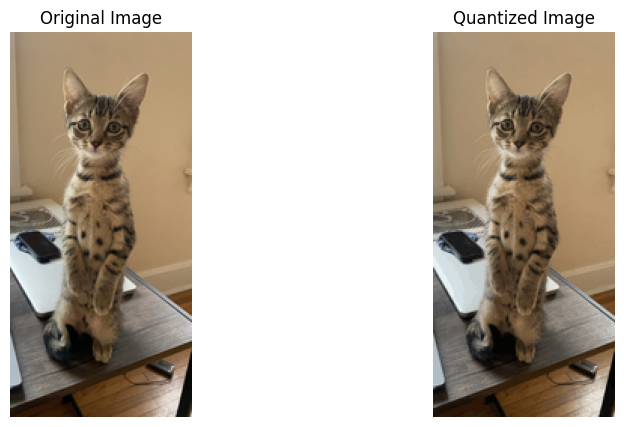

In [22]:


def display_images_side_by_side(original_image_path, quantized_image):
    '''Function to display original image next to quantized image'''
    # load and optionally resize the original image for consistent display
    original_image = Image.open(original_image_path)
    resized_original_image = resize_image(original_image_path, max_size=256)

    # create a figure to display the images
    plt.figure(figsize=(10, 5))

    # display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(resized_original_image)
    plt.title('Original Image')
    plt.axis('off')

    # display the quantized image
    plt.subplot(1, 2, 2)
    plt.imshow(quantized_image)
    plt.title('Quantized Image')
    plt.axis('off')

    plt.show()


image_path = '/Users/ianduke/Desktop/Hummus.jpg'
quantized_image = quantize_image_with_kmeans(image_path, n_clusters=400)
display_images_side_by_side(image_path, quantized_image)


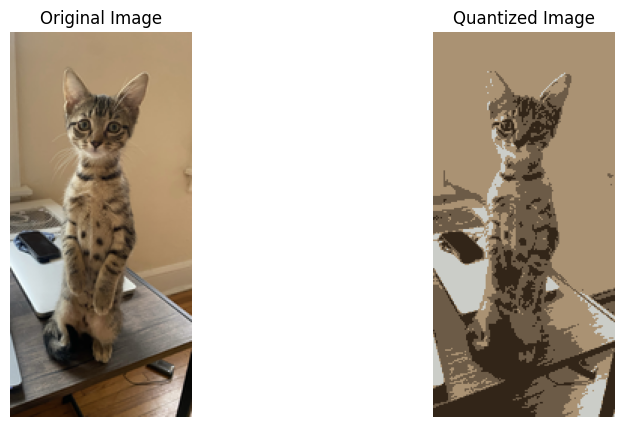

In [23]:
quantized_image = quantize_image_with_kmeans(image_path, n_clusters=4)
display_images_side_by_side(image_path, quantized_image)

Neat! We can see that-- when we apply clustering, we recreate the image
using only n_clusters colors. The vector representing each color is
approximated to it's closest centroid, and when we pick a smaller number of clusters we are left with a degraded image.

### Additional Tasks for Exploration

1. Compare the K-Means algorithm's performance with different initialization strategies (e.g., random initialization).

2. Experiment with different distance metrics for assigning data points
to clusters (e.g., Euclidean distance, Manhattan distance).

In [24]:
def euclidean_distance(a, b):
    # Computes the Euclidean distance between vectors a and b
    return np.sqrt(((a - b) ** 2).sum(axis=2))


def manhattan_distance(a, b):
    # Computes the Manhattan distance between vectors a and b
    return np.abs(a - b).sum(axis=2)


class KMeans1:
    def __init__(
            self,
            n_clusters=3,
            max_iterations=100,
            random_state=None,
            initialization='random',
            distance_metric='euclidean'):
        """
        Initialize KMeans clustering algorithm.

        Parameters:
        - n_clusters: Number of clusters (default is 3).
        - max_iterations: Maximum number of iterations (default is 100).
        - random_state: Seed for random number generation (default is None).
        - initialization: Method for initialization ('random', 'k-means++').
        - distance_metric: Distance metric for clustering ('euclidean', 'manhattan').
        """
        self.n_clusters = n_clusters
        self.max_iterations = max_iterations
        self.random_state = random_state
        self.initialization = initialization
        self.distance_metric = distance_metric
        self.centroids = None
        self.labels = None

    def initialize_centroids(self, data):
        if self.initialization == 'random':
            return data[np.random.choice(
                data.shape[0], self.n_clusters, replace=False)]
        elif self.initialization == 'k-means++':
            np.random.seed(self.random_state)
            centroids = np.zeros((self.n_clusters, data.shape[1]))
            # Step 1: Randomly select the first centroid from the data points
            centroids[0] = data[np.random.choice(data.shape[0], 1)]
            for i in range(1, self.n_clusters):
                # Step 2: Compute the distance from the nearest centroid for
                # each data point
                distances = np.min(euclidean_distance(
                    data[:, np.newaxis], centroids[:i]), axis=1)
                # Step 3: Select the next centroid with a probability
                # proportional to the square of the distance
                probabilities = distances ** 2
                probabilities /= probabilities.sum()
                centroid_index = np.random.choice(
                    data.shape[0], 1, p=probabilities)
                centroids[i] = data[centroid_index]
            return centroids
        else:
            raise ValueError("Unsupported initialization method.")

    def compute_distances(self, data, centroids):
        if self.distance_metric == 'euclidean':
            return euclidean_distance(data[:, np.newaxis], centroids)
        elif self.distance_metric == 'manhattan':
            return manhattan_distance(data[:, np.newaxis], centroids)
        elif self.distance_metric == 'squared_diff':
            return ((data[:, np.newaxis] - centroids) ** 2).sum(axis=2)
        else:
            raise ValueError("Unsupported distance metric.")

    def fit(self, data):
        """
        Fit the KMeans algorithm to the input data.

        Parameters:
        - data: Numpy array of shape (m, n) representing m data points in an n-dimensional space.
        """
        if data.shape[0] < self.n_clusters:
            raise ValueError(
                "Number of clusters cannot be more than the number of data points.")

        np.random.seed(self.random_state)
        self.centroids = self.initialize_centroids(data)

        for _ in range(self.max_iterations):
            # Assign all observations in X to the nearest centroid
            labels = self.predict(data)

            # Recalculate the centroid as the average of the observations in Cj
            new_centroids = np.zeros((self.n_clusters, data.shape[1]))
            for i in range(self.n_clusters):
                cluster_points = data[labels == i]
                if cluster_points.size == 0:  # checks for empty clusters
                    new_centroids[i] = self.initialize_centroids(data)[0]
                else:
                    new_centroids[i] = cluster_points.mean(axis=0)

            if np.allclose(
                    self.centroids,
                    new_centroids,
                    atol=1e-6):  # determines convergence
                break

            self.centroids = new_centroids

        self.labels = labels

    def predict(self, data):
        """
        Assign data points to the nearest cluster based on current centroids.

        Parameters:
        - data: Numpy array of shape (m, n) representing m data points in an n-dimensional space.

        Returns:
        - labels: Array of cluster labels assigned to each data point.
        """
        distances = self.compute_distances(data, self.centroids)
        labels = np.argmin(distances, axis=1)
        return labels

    def get_centroids(self):
        """
        Get the current centroids after fitting the algorithm.

        Returns:
        - centroids: Numpy array representing the centroids of clusters.
        """
        return self.centroids

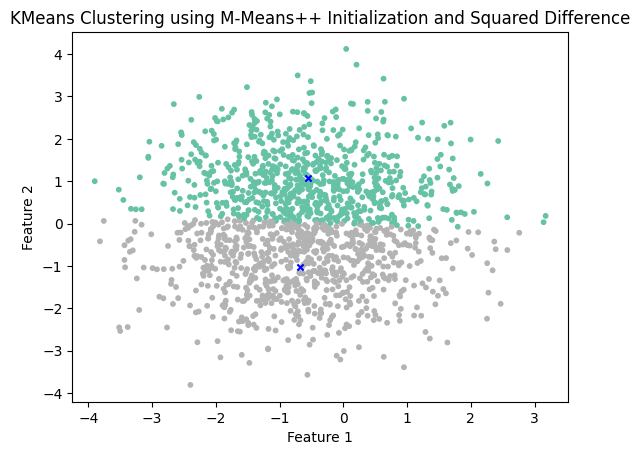

KMeans fitting time: 0.004565000534057617 seconds


In [33]:
data1 = np.random.randn(500, 2) + np.array([0, 0])
data2 = np.random.randn(500, 2) + np.array([-1, -1])
data3 = np.random.randn(500, 2) + np.array([-1, 1])
data = np.vstack((data1, data2, data3))

# Start the timer
start_time = time.time()

# Instantiate KMeans
kmeans = KMeans1(
    n_clusters=2,
    max_iterations=30,
    random_state=42,
    initialization='k-means++',
    distance_metric='squared_diff')

# Fit KMeans
kmeans.fit(data)

# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Plotting
plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels, s=10, cmap='Set2')
centroids = np.array(kmeans.centroids)
plt.scatter(centroids[:, 0], centroids[:, 1], c='blue', s=20, marker='x')
plt.title('KMeans Clustering using M-Means++ Initialization and Squared Difference')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Print the runtime
print(f"KMeans fitting time: {elapsed_time} seconds")

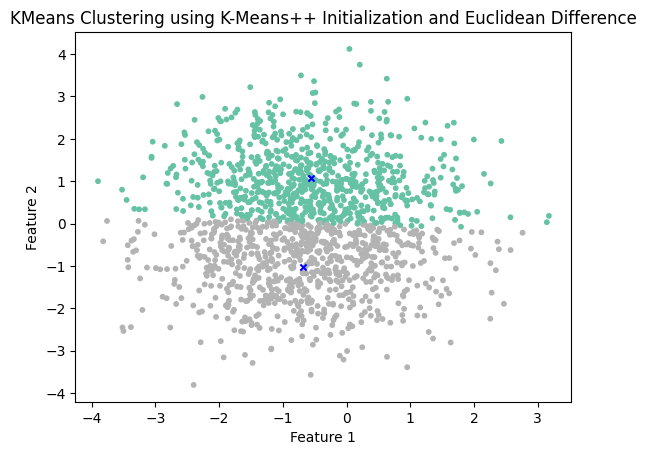

KMeans fitting time: 0.007086038589477539 seconds


In [34]:
# Start the timer
start_time = time.time()

# Instantiate KMeans
kmeans = KMeans1(
    n_clusters=2,
    max_iterations=30,
    random_state=42,
    initialization='k-means++',
    distance_metric='euclidean')

# Fit KMeans
kmeans.fit(data)

# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Plotting
plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels, s=10, cmap='Set2')
centroids = np.array(kmeans.centroids)
plt.scatter(centroids[:, 0], centroids[:, 1], c='blue', s=20, marker='x')
plt.title('KMeans Clustering using K-Means++ Initialization and Euclidean Difference')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Print the runtime
print(f"KMeans fitting time: {elapsed_time} seconds")

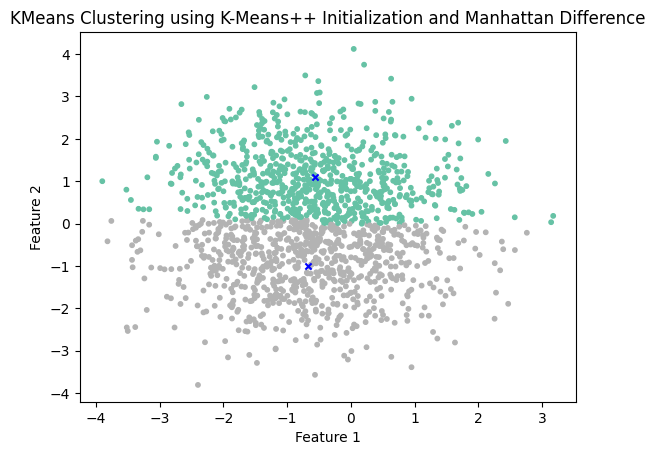

KMeans fitting time: 0.004322052001953125 seconds


In [35]:
# Start the timer
start_time = time.time()

# Instantiate KMeans
kmeans = KMeans1(
    n_clusters=2,
    max_iterations=30,
    random_state=42,
    initialization='k-means++',
    distance_metric='manhattan')

# Fit KMeans
kmeans.fit(data)

# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Plotting
plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels, s=10, cmap='Set2')
centroids = np.array(kmeans.centroids)
plt.scatter(centroids[:, 0], centroids[:, 1], c='blue', s=20, marker='x')
plt.title('KMeans Clustering using K-Means++ Initialization and Manhattan Difference')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Print the runtime
print(f"KMeans fitting time: {elapsed_time} seconds")

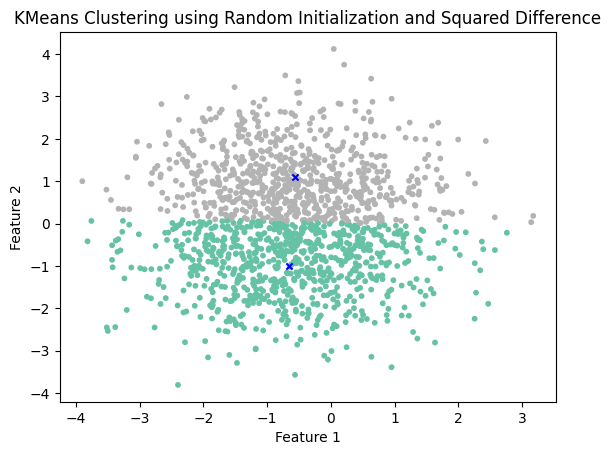

KMeans fitting time: 0.006902933120727539 seconds


In [36]:
# Start the timer
start_time = time.time()

# Instantiate KMeans
kmeans = KMeans1(
    n_clusters=2,
    max_iterations=30,
    random_state=42,
    initialization='random',
    distance_metric='squared_diff')

# Fit KMeans
kmeans.fit(data)

# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Plotting
plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels, s=10, cmap='Set2')
centroids = np.array(kmeans.centroids)
plt.scatter(centroids[:, 0], centroids[:, 1], c='blue', s=20, marker='x')
plt.title('KMeans Clustering using Random Initialization and Squared Difference')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Print the runtime
print(f"KMeans fitting time: {elapsed_time} seconds")

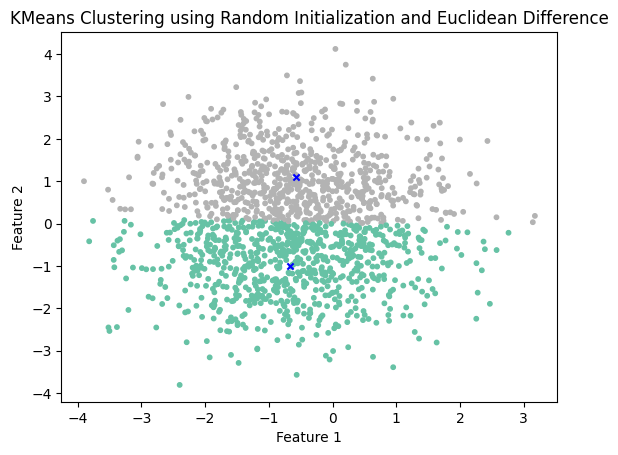

KMeans fitting time: 0.006373882293701172 seconds


In [37]:
# Start the timer
start_time = time.time()

# Instantiate KMeans
kmeans = KMeans1(
    n_clusters=2,
    max_iterations=30,
    random_state=42,
    initialization='random',
    distance_metric='euclidean')

# Fit KMeans
kmeans.fit(data)

# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Plotting
plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels, s=10, cmap='Set2')
centroids = np.array(kmeans.centroids)
plt.scatter(centroids[:, 0], centroids[:, 1], c='blue', s=20, marker='x')
plt.title('KMeans Clustering using Random Initialization and Euclidean Difference')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Print the runtime
print(f"KMeans fitting time: {elapsed_time} seconds")

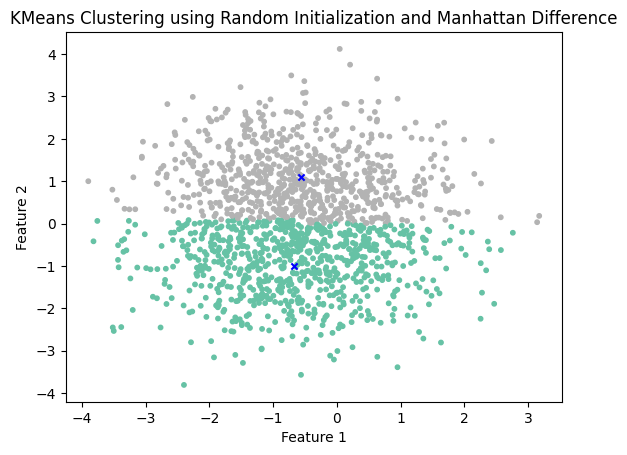

KMeans fitting time: 0.0035440921783447266 seconds


In [38]:
# Start the timer
start_time = time.time()

# Instantiate KMeans
kmeans = KMeans1(
    n_clusters=2,
    max_iterations=30,
    random_state=42,
    initialization='random',
    distance_metric='manhattan')

# Fit KMeans
kmeans.fit(data)

# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Plotting
plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels, s=10, cmap='Set2')
centroids = np.array(kmeans.centroids)
plt.scatter(centroids[:, 0], centroids[:, 1], c='blue', s=20, marker='x')
plt.title('KMeans Clustering using Random Initialization and Manhattan Difference')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Print the runtime
print(f"KMeans fitting time: {elapsed_time} seconds")


Above, we observe that changes in initialization and difference metrics
have very little impact on fitting time. While actual results of clustering deviate slightly between methods, the clusters are generally very similar.